In [1]:
!pip install nvidia-ml-py3

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [4]:
import wandb

In [17]:
# pyyaml (yaml) :: parses configuration files (YAML files)
# see https://www.cloudbees.com/blog/yaml-tutorial-everything-you-need-get-started for more information on YAML files
import yaml 

# huggingface :: datasets : dataset-handling libraries from huggingface
from datasets import load_dataset
#from datasets.filesystems import S3FileSystem # for S3 interactions

# huggingface :: transformers : transformer, trainer and tokenizer objects for the actual training
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# transformer_imports.py :: contains all our transformer imports and the MODEL DICT
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

# pytorch (torch) :: machine learning and deep learning method library
import torch

# gradient checkpointing to fit larger models (when not even 1 batch fits)
from torch.utils.checkpoint import checkpoint

# nvidia management library, interface with gpu like nvidia-smi
from pynvml import *

In [18]:
import os
import time
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import random
from tqdm import tqdm
import shutil
import nvidia_smi

import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

In [19]:
nvidia_smi.nvmlInit()

In [20]:
# nltk punkt sentence tokenizer, divides text into a list of sentences
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
!nvidia-smi

Sun Apr  2 19:26:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [23]:
def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [24]:
path_to_config = "../configs/gpt2-refl-29-mar-2023.yaml"

In [35]:
# open yaml config as a strema and load into config_dict
with open(path_to_config, "r") as stream:
    try:
        config_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print("Configuration load failed!")
        print(exc)

In [36]:
df = pd.read_csv(config_dict["data_train_path"])
df_val = pd.read_csv(config_dict["data_validation_path"])

In [37]:
df.dropna(inplace=True)  # drop NA values
triplets = df.triplet.copy()  # copy over triplets

In [38]:
val_triplets = df_val.triplet.copy()  # validation triplets

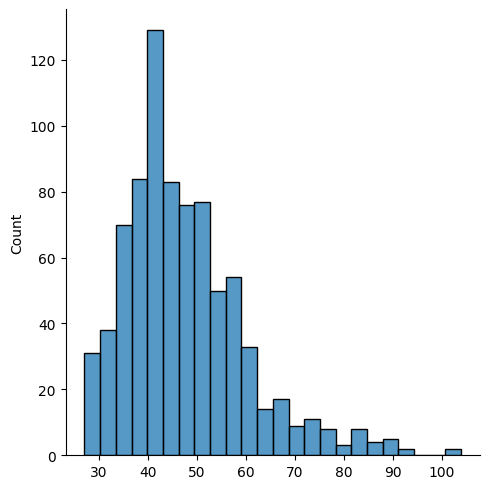

In [39]:
# how long is our training data?
doc_lengths = []
for triplet in triplets:
    tokens = nltk.word_tokenize(triplet)
    doc_lengths.append(len(tokens))
doc_lengths = np.asarray(doc_lengths)
sns.displot(doc_lengths)

In [40]:
np.average(doc_lengths)
# on average, we have ~47.5 tokens per entry, a good thing for GPT2 embedding size of 768 in gpt-small

47.53465346534654

In [41]:
model_name = config_dict['model_name']
hyperparameters = config_dict['training_settings']['hyperparameters']

In [43]:
model_name

'gpt2-xl'

In [42]:
# load gpt-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name, bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [44]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [45]:
# amount of examples passed through model before a backwards pass
batch_size = hyperparameters['batch_size']

In [46]:
class GPT2Dataset(Dataset):
    # Inherits Dataset from PyTorch, a data primitive which
    # stores samples and corresponding labels
    # custom Dataset needs init, len, and getitem
    # init runs once when instantiating Dataset object
    def __init__(self, txt_list, tokenizer, gpt2_type='gpt2-xl', max_length=256):
        self.input_ids = []
        self.attn_masks = []
        
        # for each text list, encode it using tokenizer then unpacl encodings dict into:
        # input_ids: numerical representations of our tokens
        # attn_masks: indicates which tokens should be attended to (and which are pads)
        for txt in txt_list:
            # tokenize the txt with a custom start and end token
            # encodings dict contains both our token input ids and attention mask
            # truncation will clip sentences that are too long
            # padding adds pad tokens until we reach max input sentence length 768
            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
            
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    # overrides len() to returns the number of samples in our dataset
    def __len__(self):
        return len(self.input_ids)
    # loads and returns a sample from dataset at given index idx
    # sometimes we need to do type swapping in getitem, but not here
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]
            

In [47]:
train_dataset = GPT2Dataset(triplets, tokenizer, max_length=256)
val_dataset = GPT2Dataset(val_triplets, tokenizer, max_length=256)

In [48]:
print(f"{len(train_dataset)} Training Samples")
print(f"{len(val_dataset)} Validation Samples")

808 Training Samples
95 Validation Samples


In [49]:
# Create DataLoader for training and validation datasets
# PyTorch DataLoaders wrap iterable around a Dataset to access samples easily
# We typically pass in minibatches and reshuffle data at epochs to reduce overfitting
# DataLoaders leverage python's multiprocessing to speed up data retrieval

# take training samples in random order
batch_size = config_dict['training_settings']['hyperparameters']['batch_size']
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)

# For validation, the order doesn't matter, so we read sequentially
validation_dataloader = DataLoader(val_dataset,
                                   sampler=SequentialSampler(val_dataset),
                                   batch_size=batch_size)

In [50]:
# config to instantiate model
configuration = GPT2Config.from_pretrained(model_name, output_hidden_states=False)


In [51]:
# instantiate model
model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)


In [52]:
# resize token embeddings for our custom tokens (e.g. bos_token)
model.resize_token_embeddings(len(tokenizer))

Embedding(50259, 1600)

In [53]:
device = torch.device("cuda")

In [54]:
# sends model to current device - in this case CUDA
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout)

In [26]:
# Set the seed value
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [28]:
wandb.init(
  project="gpt2-medium-reflector",
  notes="Larger training/validation dataset, using GPT2-medium",
  tags=["gpt2-medium", "reflector"],
)

time="2023-03-30T04:17:46Z" level=fatal msg="Failed to discover neuron devices" error="Unable to read device information from the driver. Make sure aws-neuron-dkms is installed and the neuron driver is accessible."


In [29]:
# all the below set the corresponding values from the configuration file config.yaml:
model_name = config_dict["model_name"]
pretrained = config_dict["pretrained"]
data_train_path = config_dict["data_train_path"]
data_validation_path = config_dict["data_validation_path"]


output_data_dir = config_dict["output_data_dir"] + "/"
output_model_dir = config_dict["output_model_dir"] + "/"

hyperparameters = config_dict["training_settings"]["hyperparameters"]
hyperparameters["learning_rate"] = float(hyperparameters["learning_rate"])
hyperparameters["weight_decay"] = float(hyperparameters["weight_decay"])

deepspeed_config = config_dict["training_settings"]["deepspeed_settings"]

In [30]:
hyperparameters

{'find_hyperparams_automatically': False,
 'num_trials': 10,
 'fp16': True,
 'deepspeed': True,
 'grad_accumulation_steps': 2,
 'eval_batch_size': 1,
 'learning_rate': 0.0003,
 'epochs': 10,
 'warmup_steps': 100,
 'epsilon': '1e-7',
 'batch_size': 2,
 'sample_every': 100,
 'seed': 42,
 'eval_steps': 10,
 'weight_decay': 0.01}

In [31]:
learning_rate = hyperparameters['learning_rate']
epsilon = float(hyperparameters['epsilon'])  # epsilon must be a float, not str
epochs = hyperparameters['epochs']
warmup_steps = float(hyperparameters['warmup_steps'])
sample_every = float(hyperparameters['sample_every'])

In [32]:
wandb.config.update(config_dict)

In [33]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [34]:
# Total num training steps is [num batches] x [num epochs]
# (not the same number as num training sample)
total_steps = len(train_dataloader) * epochs

In [35]:
# Create learning rate scheduler
# we schedule learning rate using 
# optimzer, num_warmup steps, and num_training steps
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

In [36]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [37]:
# start global timer
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):
    """
    Training Loop
    """
    wandb.watch(model)
    print(f"---Epoch {epoch_i + 1} of {epochs}---")
    print("---Training...---")
    
    # start epoch timer
    t0 = time.time()
    
    total_train_loss = 0

    # sets model into train mode, not actual backprop
    # dropout and batchnorm behave differently
    # opposite of model.eval() for inference mode
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        # grab input tokens, labels, and masks
        input_tokens = batch[0].to(device)
        # in this case, we're generating text,
        # so label tokens are the input tokens shifted
        label_tokens = batch[0].to(device)
        attn_masks = batch[1].to(device)
        
        # clear any gradients from model tensors
        # prevents any gradient accumulation
        model.zero_grad()
        
        # forward pass
        outputs = model(input_tokens,
                        labels=label_tokens,
                        attention_mask=attn_masks,
                        token_type_ids=None
                       )
        
        # grab loss from outputs
        loss = outputs[0]
        
        batch_loss = loss.item()  # detach from device with item
        total_train_loss += batch_loss
        
        # get sample every x batches
        if step % sample_every == 0 and not step == 0:
            # calculate elapsed time and print statistics
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))
            
            # set model to inference mode for testing
            model.eval()
            
            # sample model with generate() using no tokens, just let it generate
            sample_outputs = model.generate(bos_token_id=random.randint(1,30000),
                                            do_sample=True,
                                            top_k=50,
                                            max_length=200,
                                            top_p=0.95,
                                            num_return_sequences=1
                                           )
            
            for i, sample_output in enumerate(sample_outputs):
                out = tokenizer.decode(sample_output, skip_special_tokens=True)
                print(f"{i}: {out}")
            
            # back to train mode
        
        # backpropagation step
        # computes dloss/dx for every parameter x which has requires_grad=True.
        # updates gradient values
        # x.grad += dloss/dx
        loss.backward()
        
        # step optimizer
        # updates the value of x using the gradient x.grad
        # x += -lr * x.grad
        optimizer.step()
        
        # step scheduler
        # tells scheduler to increase learning rate
        # using our warmup steps
        scheduler.step()
        
    print("---Done Training Epoch!---")
    # calculate average loss over all batches
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    # measure how long the epoch took
    training_time = format_time(time.time() - t0)
    
    print(f"---Average training loss {avg_train_loss} ---")
    print(f"---Training epoch took {training_time} ---")
    
    """
    Validation
    """
    print("---Running Validation...---")
    
    # start batch timer
    t0 = time.time()
    
    # set model to inference mode
    model.eval()
    
    total_eval_loss = 0
    nb_eval_steps = 0
    
    # evaluate data for one epoch
    for batch in validation_dataloader:
        # grab input tokens, labels, and masks
        input_tokens = batch[0].to(device)
        # in this case, we're generating text,
        # so label tokens are the input tokens shifted
        label_tokens = batch[0].to(device)
        attn_masks = batch[1].to(device)
        
        # freeze gradients
        with torch.no_grad():
            outputs = model(input_tokens,
                            attention_mask=attn_masks,
                            labels=label_tokens)
            
            loss = outputs[0]
        
        batch_loss = loss.item()
        total_eval_loss += batch_loss
        
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation took: {validation_time}")
    
    # save all training statistics from the epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        })
    # log training data to wandb as well
    wandb.log({
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        })
    

print("---Training Complete!")
print(f"---Total training time took {format_time(time.time()-total_t0)}")


---Epoch 1 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    404. Loss: 0.62939453125.   Elapsed: 0:00:46.
0:  bipartisanPrompt: To start, what are the steps to reduce your stress, what are the steps to help you feel, what steps to make your hair healthy, what steps will help you feel you need to have rest and ease, what steps will help you with stress reduction, what steps will make it healthier in your health, which steps will relieve your boredom
Reflection: You feel healthier than before you had stress, you will relieve you boredom and improve your health



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    404. Loss: 0.18817535042762756.   Elapsed: 0:01:33.
0:  increasingPrompt: Now, what is one thing about your smoking habit that you would like to change?
Response: I want to be more social, not just social smoking
Reflection: You want to be more socially aware and feel less ashamed about how you have



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    404. Loss: 0.32809504866600037.   Elapsed: 0:02:20.
0: dayPrompt: Now, what will it look like when you have changed this thing in your smoking habit?
Response:  i dont feel sure and want to feel safe
Reflection: You're worried that others will find out about your habit and you want to prevent others from finding out. 



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    404. Loss: 0.29373985528945923.   Elapsed: 0:03:08.
0:  HangPrompt: Finally, what are the steps you need to take to make this change?
Response: focus on smoking less
Reflection: Smoking is a coping mechanism for you when you are stressed or tired. You will try to use this mechanism to focus on smoking less.

---Done Training Epoch!---
---Average training loss 0.763100622535342 ---
---Training epoch took 0:03:11 ---
---Running Validation...---
Validation Loss: 0.23421702867684266
Validation took: 0:00:06
---Epoch 2 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    404. Loss: 0.3505067229270935.   Elapsed: 0:00:49.
0:  foodsPrompt: Now, what is one thing about your smoking habit that you would like to change?
Response: i would like to eliminate smoking completely
Reflection: You want to stop smoking completely.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    404. Loss: 0.19214048981666565.   Elapsed: 0:01:37.
0:  trailPrompt: Now, could you tell me the things you dont like about smoking?
Response:  It has been said that it is a dependency, and it is only a matter of time till I get rid of it. 
Reflection: You realize that smoking is an addictive behavior that leaves you feeling stressed and anxious. 



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    404. Loss: 0.22003981471061707.   Elapsed: 0:02:26.
0: intendPrompt: Now, what is one thing about your smoking habit that you would like to change?
Response: I want to stop smoking for good
Reflection: You want to quit smoking altogether. 



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    404. Loss: 0.08908096700906754.   Elapsed: 0:03:14.
0:  surroundPrompt: Now, what is one thing about your smoking habit that you would like to change?
Response: I don't like to smoke around my kids, they hate it
Reflection: You don't want your kids to find out that you smoked in front of them.

---Done Training Epoch!---
---Average training loss 0.18718573988627385 ---
---Training epoch took 0:03:17 ---
---Running Validation...---
Validation Loss: 0.1995182284153998
Validation took: 0:00:05
---Epoch 3 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    404. Loss: 0.06720206886529922.   Elapsed: 0:00:45.
0:  reflexPrompt: To start, what is the thing you like most about smoking?
Response: the rush of pleasure when I inhale and exhale a cigarette
Reflection: Smoking stimulates your brain to feel high. Smoking also makes you want to smoke more.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    404. Loss: 0.10506068915128708.   Elapsed: 0:01:31.
0:  displayPrompt: What will it look like when you have made this change in your smoking habit?
Response: I'll be a much more relaxed person
Reflection: Smoking is negatively affecting your mental health, so you expect to be a much less stressed person.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    404. Loss: 0.05046888068318367.   Elapsed: 0:02:16.
0:  pastorPrompt: Now, what is one thing about your smoking habit that you would like to change?
Response: to smoke less, I smoke less abusevely, or I quit completely
Reflection: You realize that quitting smoking is crucial to succeeding in life, so you are making changes to make that happen.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    404. Loss: 0.10062018781900406.   Elapsed: 0:03:01.
0:  illicitPrompt: Finally, what are the steps you need to take to make this change?
Response: To stop smoking for good
Reflection: You need to quit smoking for good.

---Done Training Epoch!---
---Average training loss 0.11559305886857875 ---
---Training epoch took 0:03:04 ---
---Running Validation...---
Validation Loss: 0.18640298939620456
Validation took: 0:00:05
---Epoch 4 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    404. Loss: 0.19422319531440735.   Elapsed: 0:00:45.
0:  LiberationPrompt: Now, could you tell me the things you don’t like about smoking?
Response: It makes people dizzy.
Reflection: You don't like how smoking can affect your health.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    404. Loss: 0.10472530126571655.   Elapsed: 0:01:30.
0:  NamPrompt: To start, what is the thing you like most about smoking?
Response: The feel
Reflection: You enjoy the way the act of smoking makes you feel.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    404. Loss: 0.05222635716199875.   Elapsed: 0:02:15.
0: IONPrompt: What will it look like when you have made this change in your smoking habit?
Response: i wont feel the need to smoke
Reflection: You realize that tobacco dependence is a lifelong process, and you would like to quit.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    404. Loss: 0.09672541916370392.   Elapsed: 0:03:01.
0:  glimpsePrompt: Now, what is the thing you like least about smoking?
Response: I understand it is harming others by second hand smoke
Reflection: You dislike second hand smoke and its effects on others around you.

---Done Training Epoch!---
---Average training loss 0.08597513466225107 ---
---Training epoch took 0:03:03 ---
---Running Validation...---
Validation Loss: 0.18568455567583442
Validation took: 0:00:05
---Epoch 5 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    404. Loss: 0.06235275790095329.   Elapsed: 0:00:46.
0:  LaurePrompt: Now, what is one thing about your smoking habit that you would like to change?
Response: Smoking a lot when i'm drinking alcohol
Reflection: You would like to reduce the amount of cigarettes you smoke when you are drinking alcohol.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    404. Loss: 0.033402569591999054.   Elapsed: 0:01:33.
0: ismPrompt: Now, what is the thing you like least about smoking?
Response: the smell
Reflection: You dislike the smell of tobacco and how it might affect others around you.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    404. Loss: 0.04050188884139061.   Elapsed: 0:02:21.
0: ounPrompt: To start, could you tell me the things that you like about smoking?
Response: It helps me blend in with friends and gives me some much needed social life
Reflection: Smoking helps you connect with others. 



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    404. Loss: 0.04085872322320938.   Elapsed: 0:03:09.
0:  electionPrompt: Now, what is the thing you like least about smoking?
Response: the smell of ciggies and the bad it does to my health
Reflection: You dislike the smell of cigarettes and the health effects they have on you. 

---Done Training Epoch!---
---Average training loss 0.05924882520783213 ---
---Training epoch took 0:03:12 ---
---Running Validation...---
Validation Loss: 0.1902607030545672
Validation took: 0:00:06
---Epoch 6 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    404. Loss: 0.05026599392294884.   Elapsed: 0:00:48.
0:  crazyPrompt: Now, what is one thing about your smoking habit that you would like to change?
Response: I wish there was a cigarette that didn't cause cancer.
Reflection: You'd like to find a way to keep smoking without the danger to your health.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    404. Loss: 0.03455064445734024.   Elapsed: 0:01:37.
0:  benchPrompt: What will it look like when you have made this change in your smoking habit?
Response: I will feel better about myself
Reflection: You will feel better about yourself because of the changes you are making.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    404. Loss: 0.036081165075302124.   Elapsed: 0:02:26.
0:  incorporatedPrompt: To start, what is the thing you like most about smoking?
Response: The relaxing sensation
Reflection: Nicotine is a relaxing drug that you get from smoking tobacco cigarettes. It gives you a rush of pleasure when you smoke.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    404. Loss: 0.029528770595788956.   Elapsed: 0:03:14.
0: PeterPrompt: Finally, what are the steps you need to take to make this change?
Response: i would need to force myself to smoke less cigarettes per day
Reflection: You realize that you must promise yourself to stick to your decision to smoke less.

---Done Training Epoch!---
---Average training loss 0.04542385766024489 ---
---Training epoch took 0:03:17 ---
---Running Validation...---
Validation Loss: 0.2092767406332617
Validation took: 0:00:06
---Epoch 7 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    404. Loss: 0.030979104340076447.   Elapsed: 0:00:49.
0: uringPrompt: Now, what is the thing you like least about smoking?
Response: The cost
Reflection: You are aware of the financial burden that smoking puts on you.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    404. Loss: 0.03029443882405758.   Elapsed: 0:01:38.
0:  reproductivePrompt: To start, could you tell me the things that you like about smoking?
Response:  Smoking gives me a pleasurable and happy feeling. 
Reflection: Smoking makes you feel good. 



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    404. Loss: 0.03135325014591217.   Elapsed: 0:02:26.
0:  zonePrompt: What will it look like when you have made this change in your smoking habit?
Response: I think my hair will be shinier and my lung capacity will also be better
Reflection: You know smoking is harming your appearance and health, and you believe positive strides can be made by changing your habit.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    404. Loss: 0.02435462735593319.   Elapsed: 0:03:15.
0:  commitsPrompt: What will it look like when you have made this change in your smoking habit?
Response: I will be healthier
Reflection: You will feel better about yourself, your body, and your health by reducing your smoking amount. 

---Done Training Epoch!---
---Average training loss 0.039889758913823875 ---
---Training epoch took 0:03:17 ---
---Running Validation...---
Validation Loss: 0.21182089857757092
Validation took: 0:00:06
---Epoch 8 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    404. Loss: 0.060037821531295776.   Elapsed: 0:00:48.
0:  ironyPrompt: What will it look like when you have made this change in your smoking habit?
Response: I think my hair will be shinier and my lung capacity will also be better
Reflection: You believe by making this change, your hair will look shinier and your lung capacity will improve.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    404. Loss: 0.041968245059251785.   Elapsed: 0:01:38.
0:  SahPrompt: To start, what is the thing you like most about smoking?
Response: It looks good and makes me calm
Reflection: You like how the act of smoking makes you look and the calmingt effect it gives you.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    404. Loss: 0.027733517810702324.   Elapsed: 0:02:27.
0:  BryanPrompt: To start, could you tell me the things that you like about smoking?
Response:  It helps to start a conversation
Reflection: smoking is good at breaking the ice. 



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    404. Loss: 0.0387302041053772.   Elapsed: 0:03:15.
0:  spiritsPrompt: What will it look like when you have made this change in your smoking habit?
Response: instead of having the urge to smoke every 2 hours, i will smoke a cigarette maybe once a day
Reflection: You will be less dependent on smoking, and have less impulse to smoke. 

---Done Training Epoch!---
---Average training loss 0.03550311201943619 ---
---Training epoch took 0:03:18 ---
---Running Validation...---
Validation Loss: 0.21338237709521005
Validation took: 0:00:06
---Epoch 9 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    404. Loss: 0.030316045507788658.   Elapsed: 0:00:49.
0:  seesPrompt: Now, what is one thing about your smoking habit that you would like to change?
Response: At least, the quantity and frequency
Reflection: Living a healthier life is important to you, so you want to at least smoke less cigarettes less often. 



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    404. Loss: 0.028604649007320404.   Elapsed: 0:01:38.
0:  hungryPrompt: Now, could you tell me the things you dont like about smoking?
Response: I'm worried about cancer.
Reflection: You're worried about your health.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    404. Loss: 0.036465294659137726.   Elapsed: 0:02:26.
0:  PTPrompt: Now, what is one thing about your smoking habit that you would like to change?
Response: I would like to have more control over when I smoke
Reflection: You want to be less dependent on cigarettes



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    404. Loss: 0.02871249057352543.   Elapsed: 0:03:15.
0: üPrompt: Now, what is one thing about your smoking habit that you would like to change?
Response: I want to quit smoking forever.
Reflection: You want to stop smoking for good.

---Done Training Epoch!---
---Average training loss 0.031852848500492845 ---
---Training epoch took 0:03:18 ---
---Running Validation...---
Validation Loss: 0.22086942164848247
Validation took: 0:00:06
---Epoch 10 of 10---
---Training...---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    404. Loss: 0.03145574405789375.   Elapsed: 0:00:49.
0: rucePrompt: Now, what is the thing you like least about smoking?
Response: the smell
Reflection: The smell of cigarettes stays in your hair and clothes after you've smoked, and you find it unpleasant.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    404. Loss: 0.02658211626112461.   Elapsed: 0:01:38.
0:  derivativesPrompt: Finally, what are the steps you need to take to make this change?
Response: i need to be less impulsive
Reflection: You realize that your addiction to cigarettes is a survival mechanism for you when you are stressed or don't feel safe. You will try to detatch yourself from this impulse.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    404. Loss: 0.030477575957775116.   Elapsed: 0:02:26.
0: Prompt: Now, what will it look like when you have changed this thing in your smoking habit?
Response: I'm going to have more money to spend on more impoertant things
Reflection: You are going to spend the extra money on things that will make you happy.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    404. Loss: 0.025951290503144264.   Elapsed: 0:03:16.
0:  rememberingPrompt: Finally, what are the steps you need to take to make this change?
Response: Occupy myself with something else
Reflection: You have to find something else to be occupied with.

---Done Training Epoch!---
---Average training loss 0.02904104813472322 ---
---Training epoch took 0:03:18 ---
---Running Validation...---
Validation Loss: 0.22764717360648015
Validation took: 0:00:06
---Training Complete!
---Total training time took 0:33:10


In [38]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Validation Loss,Training Time,Validation Time
epoch,,,,
1,0.76,0.23,0:03:11,0:00:06
2,0.19,0.20,0:03:17,0:00:05
3,0.12,0.19,0:03:04,0:00:05
4,0.09,0.19,0:03:03,0:00:05
5,0.06,0.19,0:03:12,0:00:06
6,0.05,0.21,0:03:17,0:00:06
7,0.04,0.21,0:03:17,0:00:06
8,0.04,0.21,0:03:18,0:00:06
9,0.03,0.22,0:03:18,0:00:06


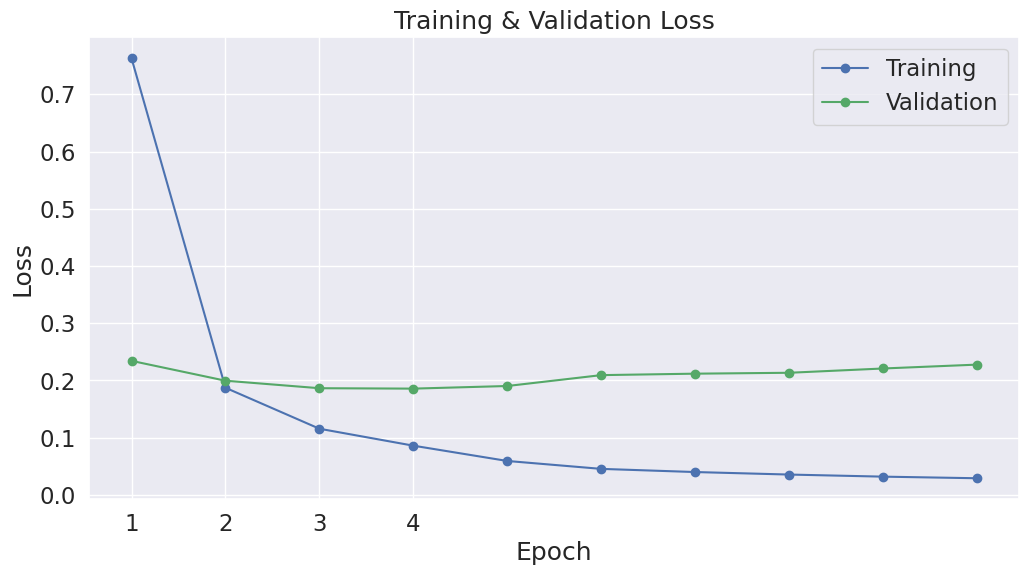

In [39]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [41]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 292 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 1024)
transformer.wpe.weight                                  (1024, 1024)

==== First Transformer ====

transformer.h.0.ln_1.weight                                  (1024,)
transformer.h.0.ln_1.bias                                    (1024,)
transformer.h.0.attn.c_attn.weight                      (1024, 3072)
transformer.h.0.attn.c_attn.bias                             (3072,)
transformer.h.0.attn.c_proj.weight                      (1024, 1024)
transformer.h.0.attn.c_proj.bias                             (1024,)
transformer.h.0.ln_2.weight                                  (1024,)
transformer.h.0.ln_2.bias                                    (1024,)
transformer.h.0.mlp.c_fc.weight                         (1024, 4096)
transformer.h.0.mlp.c_fc.bias                                (4096,)
transformer.h.0.mlp.c_proj.weight                       (4096

In [41]:
def inference_reflector(model, path_to_data, config_dict):
    # import the data we are inferencing reflector with
    # set of incomplete reflections which offer a good understanding of the reflector
    df = pd.read_csv(path_to_data)
    
    # set model to inference mode for testing
    model.eval()
    
    # de-nest yaml config
    generation_config = config_dict['refgen']

    for index, row in df.iterrows():
        # sample model with generate() using no tokens, just let it generate
        sample_outputs = model.generate(bos_token_id=random.randint(1,30000),
                                        temperature = config['temperature'],
                                        # flag to use a sampling technique or greedy
                                        do_sample=config['do_sample'],
                                        # penalize model for duplicating words
                                        repetition_penalty = config['repetition_penalty'],
                                        # of proposed words, only select from top k of them
                                        top_k=config['top_k'],
                                        # max amount of tokens to generate
                                        max_length=config['max_length'],
                                        # of propsed words, select from the words that add up to top_p value
                                        # e.g. top_p=0.26 x(0.15),y(0.1),z(0.05)
                                        # only select from x and y (0.15+0.1+0.05=0.3 which is too high)
                                        top_p=config['top_p'],
                                        # num of independently computed returned sequences for each element in the batch.
                                        num_return_sequences=config['num_return_sequences']
                                       )
    
        # after sampling model, decode tokens and print
        for i, sample_output in enumerate(sample_outputs):
            out = tokenizer.decode(sample_output, skip_special_tokens=True)
            print(f"===========================")
            print(f"{i}: {out}")
            print(f"===========================")
            
            

In [65]:
device

device(type='cuda')

In [43]:
model.eval()
generation_config = config_dict['refgen']
config = config_dict

text = "<|startoftext|>Prompt: What do you want to change in your smoking?\nResponse: I don't want to change anything in my smoking.\n\n"
# encode the input text into tokens using the tokenizer
tokenized_text = tokenizer.encode(
    text, return_tensors="pt", padding=True, truncation=True
)
encodings_dict = tokenizer('<|startoftext|>'+ text + '<|endoftext|>', truncation=True, max_length=256, padding="max_length")

input_ids = torch.tensor(encodings_dict['input_ids'])
input_ids = tokenized_text.to(device)

# sample model with generate() using no tokens, just let it generate
with torch.no_grad():
    sample_outputs = model.generate(input_ids,
                                    bos_token_id=random.randint(1,30000),
                                    temperature = 0.8,
                                    # flag to use a sampling technique or greedy
                                    do_sample=generation_config['do_sample'],
                                    # penalize model for duplicating words
                                    repetition_penalty = 1.1,
                                    pad_token_id=tokenizer.pad_token_id,
                                    # of proposed words, only select from top k of them
                                    top_k=generation_config['top_k'],
                                    # max amount of tokens to generate
                                    max_length=256,
                                    # of propsed words, select from the words that add up to top_p value
                                    # e.g. top_p=0.26 x(0.15),y(0.1),z(0.05)
                                    # only select from x and y (0.15+0.1+0.05=0.3 which is too high)
                                    top_p=generation_config['top_p'],
                                    # num of independently computed returned sequences for each element in the batch.
                                    num_return_sequences=1
                                   )
    output = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)
    print(output)

Prompt: What do you want to change in your smoking?
Response: I don't want to change anything in my smoking.

Reflection: You feel that nothing in your smoking habit will affect you negatively, and you would like no changes to be made.


In [44]:
# saving and loading the finetuned model
output_dir = '../models/gpt2-mi-reflector/'
tokenizer_dir = '../models/gpt2-mi-reflector/'

# create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# create output directory if needed
if not os.path.exists(tokenizer_dir):
    os.makedirs(tokenizer_dir)
    
    
print(f"Saving model to {output_dir}")

Saving model to ../models/gpt2-mi-reflector/


In [47]:
# Save trained model, configuration and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(tokenizer_dir)

('../models/gpt2-mi-reflector/tokenizer_config.json',
 '../models/gpt2-mi-reflector/special_tokens_map.json',
 '../models/gpt2-mi-reflector/vocab.json',
 '../models/gpt2-mi-reflector/merges.txt',
 '../models/gpt2-mi-reflector/added_tokens.json')

In [48]:
# save training arguments with trained model
torch.save(model.state_dict(), os.path.join(output_dir, 'training_args.bin'))

In [ ]:
# # Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

In [42]:
for step, batch in enumerate(train_dataloader):
    # grab input tokens, labels, and masks
    input_tokens = batch[0]
    # in this case, we're generating text,
    # so label tokens are the input tokens shifted
    label_tokens = batch[0]
    attn_masks = batch[1]
    
    decoded = tokenizer.decode(input_tokens[0], skip_special_tokens=False)
    print(decoded)
    
    

<|startoftext|> Prompt: To start, what is the thing you like most about smoking?
Response: to see the smoke
Reflection: You enjoy seeing the sight of smoke.
<|endoftext|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>
<|startoftext|> Prompt: Now, what is one thing about your smoking habit that you would like to change?
Respon